In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
zipped = !ls ./zippedData/
zipped = list(zipped)
path = "./zippedData/"
zipped_files = [path+x for x in zipped]
zipped_files

['./zippedData/bom.movie_gross.csv.gz',
 './zippedData/imdb.name.basics.csv.gz',
 './zippedData/imdb.title.akas.csv.gz',
 './zippedData/imdb.title.basics.csv.gz',
 './zippedData/imdb.title.crew.csv.gz',
 './zippedData/imdb.title.principals.csv.gz',
 './zippedData/imdb.title.ratings.csv.gz',
 './zippedData/rt.movie_info.tsv.gz',
 './zippedData/rt.reviews.tsv',
 './zippedData/rt.reviews.tsv.gz',
 './zippedData/tmdb.movies.csv.gz',
 './zippedData/tn.movie_budgets.csv.gz']

In [4]:
def read_all(namelist):
    name_dict = {}
    for filename in namelist:
        name = filename[13:-7]
        if filename.endswith('csv.gz'):
            tmp_df = pd.read_csv(filename)
            name_dict[name] = tmp_df
        elif filename.endswith('tsv.gz'):
        #both tsv are encoded in ascii per cmd line and chardet, but for some reason 'latin' appears to do the trick:
            tmp_df = pd.read_csv(filename, sep='\t', encoding='latin')
            name_dict[name] = tmp_df
        #in case there are any additional files in the dir
        else:
            continue
    return name_dict
            

In [5]:
df_dict = read_all(zipped_files)
print(df_dict.keys())
type(df_dict['bom.movie_gross'])


dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tn.movie_budgets'])


pandas.core.frame.DataFrame

In [9]:
for df in df_dict.keys():
    print(df, df_dict[df].head())

bom.movie_gross                                          title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   
3                                    Inception     WB     292600000.0   
4                          Shrek Forever After   P/DW     238700000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
3     535700000  2010  
4     513900000  2010  
imdb.name.basics       nconst       primary_name  birth_year  death_year  \
0  nm0061671  Mary Ellen Bauder         NaN         NaN   
1  nm0061865       Joseph Bauer         NaN         NaN   
2  nm0062070         Bruce Baum         NaN         NaN   
3  nm0062195       Axel Baumann         NaN         NaN   
4  nm0062798        Pete Baxter         NaN         NaN   

                             

In [10]:
#rt.reviews.tsv does not read: error encoding
# pd.read_csv(path+zipped_both[1], sep='\t').head(2)
# import chardet
# with open(path+zipped_both[1], 'rb') as raw:
#     result = chardet.detect(raw.read(7000))
    
# print(result)

#interesting points: 1) you don't need to unzip before reading, 2, pandas reads the .gz with encoding ascii, but does
#read the .tsv with same encoding, throws error, would like to know how to check the specific byte referenced as error?
# pd.read_csv(path+zipped[16], sep='\t', encoding='ascii',).tail(2)
# zipped[16]

In [11]:
bom_gross_df = df_dict['bom.movie_gross']
#bom_gross_df['foreign_gross'] = pd.to_numeric(bom_gross_df.foreign_gross.str.replace(',', ''))
bom_gross_df.dtypes

title              object
studio             object
domestic_gross    float64
foreign_gross      object
year                int64
dtype: object

In [13]:
bom_gross_df['total_gross'] = bom_gross_df['domestic_gross'] + bom_gross_df['foreign_gross']

TypeError: unsupported operand type(s) for +: 'float' and 'str'

In [ ]:
bom_gross_df.total_gross.head(10).plot(kind='box');

In [15]:
budgets_df = df_dict['tn.movie_budgets']

In [16]:
budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [17]:
budgets_df['worldwide_gross'] = budgets_df.worldwide_gross.str.replace('$', '').str.replace(',', '').astype('int')

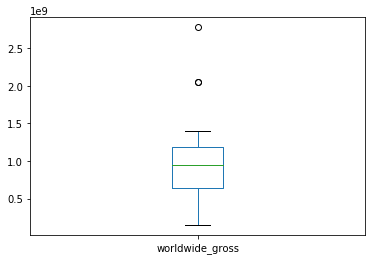

In [18]:
budgets_df.worldwide_gross.head(20).plot(kind='box')

In [19]:
budgets_df.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross       int64
dtype: object

In [20]:
budgets_df['production_budget'] = budgets_df.production_budget.str.replace('$', '').str.replace(',', '').astype('int')

In [21]:
budgets_df['profit'] = budgets_df.worldwide_gross - budgets_df.production_budget
budgets_df.sort_values(by='profit', ascending=False).head(20)
len(budgets_df)

5782

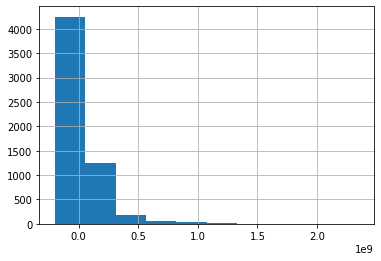

In [87]:
budgets_df.profit.hist()

In [89]:
movie_info_df = df_dict['rt.movie_info']
movie_info_df.genre.value_counts().head(20)
#movie_info_df.columns

Drama                                               151
Comedy                                              110
Comedy|Drama                                         80
Drama|Mystery and Suspense                           67
Art House and International|Drama                    62
Action and Adventure|Drama                           42
Action and Adventure|Drama|Mystery and Suspense      40
Drama|Romance                                        35
Comedy|Romance                                       32
Art House and International|Comedy|Drama             31
Horror                                               31
Action and Adventure|Science Fiction and Fantasy     24
Comedy|Drama|Romance                                 23
Classics|Drama                                       21
Action and Adventure|Mystery and Suspense            20
Action and Adventure                                 19
Classics|Drama|Mystery and Suspense                  18
Horror|Mystery and Suspense                     

In [90]:
len(movie_info_df)

1560

In [22]:
df_dict.keys()

dict_keys(['bom.movie_gross', 'imdb.name.basics', 'imdb.title.akas', 'imdb.title.basics', 'imdb.title.crew', 'imdb.title.principals', 'imdb.title.ratings', 'rt.movie_info', 'rt.reviews', 'tmdb.movies', 'tn.movie_budgets'])

In [26]:
df_dict['imdb.title.basics'].genres.value_counts()

Documentary                 32185
Drama                       21486
Comedy                       9177
Horror                       4372
Comedy,Drama                 3519
                            ...  
Comedy,Musical,War              1
Adventure,Horror,Western        1
Action,Musical,Thriller         1
Animation,Music,Sci-Fi          1
Documentary,Musical,News        1
Name: genres, Length: 1085, dtype: int64